In [75]:
!pip install mplfinance


In [76]:
pip install arch

#MODULES

In [77]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import math
#For the LSTM task
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")


In [78]:
df_eth = pd.read_csv('ETH-USD.csv')
df_eth = df_eth.reset_index()

df_xrp = pd.read_csv('xrp.csv')
df_xrp = df_xrp.reset_index()




In [79]:
df_bit = pd.read_csv('bitcoin cash.csv')
df_bit = df_bit.reset_index()

In [80]:
print(df_eth.shape)
print(df_xrp.shape)
print(df_bit.shape)


(2212, 8)
(2536, 8)
(1612, 8)


In [81]:
def data_setting(df):
  df['Date']=pd.to_datetime(df['Date'])
  df=df[~(df['Date']<'2017-11-09')]
  df=df[~(df['Date']>'2021-08-26')]
  return df

In [82]:
df_eth=data_setting(df_eth) 
df_xrp=data_setting(df_xrp)
df_bit=data_setting(df_bit)

In [83]:
print(df_eth.shape)
print(df_xrp.shape)
print(df_bit.shape)


(1387, 8)
(1387, 8)
(1387, 8)


In [48]:
'''
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
df["Date"] = df["Date"].apply(mdates.date2num)
ohlc= df[['Date', 'Open', 'High', 'Low','Close']].copy()
f1, ax = plt.subplots(figsize = (16,6))
# plot the candlesticks
candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Saving image
plt.show()
'''

'\nfrom mpl_finance import candlestick_ohlc\nimport matplotlib.dates as mdates\ndf["Date"] = df["Date"].apply(mdates.date2num)\nohlc= df[[\'Date\', \'Open\', \'High\', \'Low\',\'Close\']].copy()\nf1, ax = plt.subplots(figsize = (16,6))\n# plot the candlesticks\ncandlestick_ohlc(ax, ohlc.values, width=.6, colorup=\'green\', colordown=\'red\')\nax.xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m\'))\n# Saving image\nplt.show()\n'

In [49]:
df_xrp.head()

,index,Date,Open,High,Low,Close,Volume,Currency
0,0,2015-01-22,0.01523,0.01750,0.01523,0.01602,0,USD
1,1,2015-01-23,0.01602,0.01700,0.01600,0.01600,0,USD
2,2,2015-01-24,0.01600,0.01739,0.01500,0.01739,0,USD
3,3,2015-01-25,0.01739,0.01739,0.01560,0.01700,0,USD
4,4,2015-01-26,0.01700,0.01750,0.01469,0.01469,0,USD


In [50]:
df_bit.head()

,index,Date,Open,High,Low,Close,Volume,Currency
0,0,2017-08-03,399.00,435.00,302.10,327.40,187932,USD
1,1,2017-08-04,327.40,354.00,220.50,220.61,355744,USD
2,2,2017-08-05,220.61,277.45,194.66,210.00,330684,USD
3,3,2017-08-06,210.00,222.99,190.10,217.75,292112,USD
4,4,2017-08-07,217.75,370.00,215.00,320.00,934696,USD


#Volatility Calculation

In [106]:
def volatility(df):
  df['log_price'] = np.log(df['Close']) #Firstly we should take the logarithmic return from prices
  df['pct_change'] = df['log_price'].diff() #after that let's take difference
  df['stdev'] = df['pct_change'].rolling(window=30, center=False).std()
  df['Volatility'] = df['stdev'] * (365**0.5) # Annualize.

  plt.figure(figsize=(16,6))
  df['Volatility'].plot()
  plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
  plt.show()

  
  return df




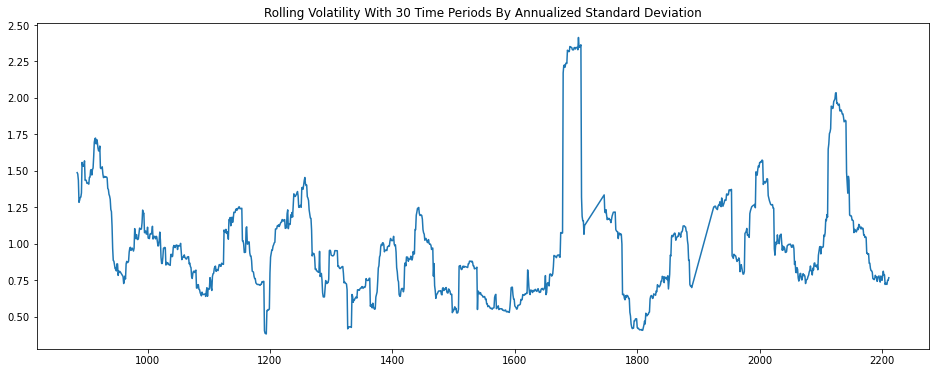

In [107]:
df_eth=volatility(df_eth)


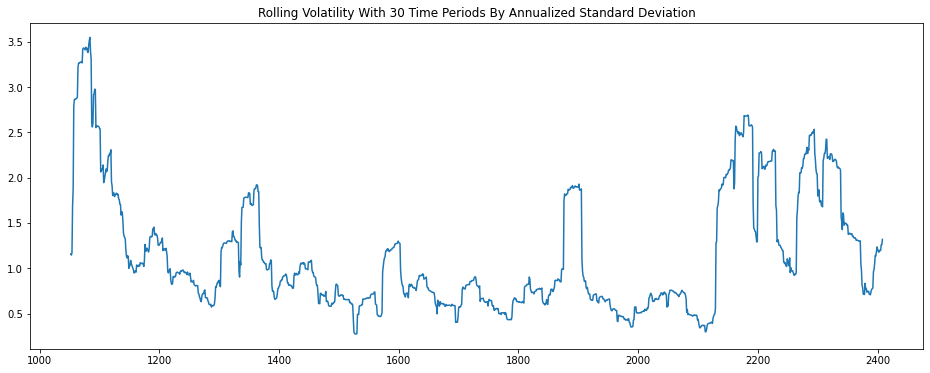

In [86]:
df_xrp=volatility(df_xrp)


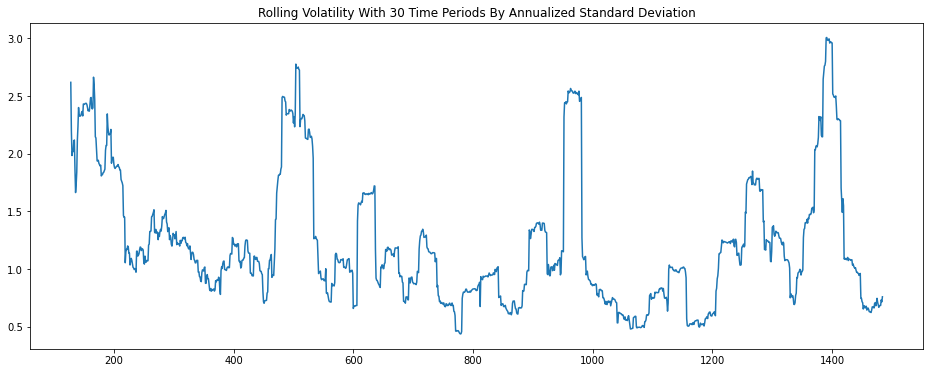

In [87]:
df_bit=volatility(df_bit)

#Models

###Evaluation with RSME

\begin{align}
         RSME= \frac{\sqrt(\sum_{n=1}^{\infty}(\hat{X_i}-X_i))^2}T
    \end{align}

In [88]:
def rmse_tr(predictions, targets): 
  return np.sqrt(((predictions - targets) ** 2).mean())



##GARCH

$$\sigma^2(t) = \alpha \times \sigma^2(t-1) + \beta \times e^2(t-1) + w$$

In [89]:
def garch_model(df):
  df = df.drop(["Date"], axis=1)


  plt.figure(figsize=(16,6))
  df['Volatility'].plot()
  plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
  plt.show()



  df = df.dropna()



  vol = df["Volatility"] #* 100


  am = arch_model(vol, vol='Garch', p=1, o=1, q=1, dist='Normal')


  res1 = am.fit()
  res1.summary()

  df1 = pd.DataFrame(columns=['test', 'I'])

  df1['test'] = res1.resid 
  df1.loc[df1['test'] < 0, 'I'] = 1
  df1["I"] = df1["I"].fillna(0)

  df['forecast_vol'] = np.sqrt(res1.params['omega'] + res1.params['alpha[1]'] * res1.resid**2 + res1.params['gamma[1]'] * res1.resid**2 * df1['I'] + res1.conditional_volatility**2 * res1.params['beta[1]'] ) ## Scaled from 0.1 to 0.01 when *3 then rmse minimum 0.49788 else 0.619080



  plt.figure(figsize=(16,6))
  df["Volatility"].plot()
  df["forecast_vol"].plot()
  plt.title("Real Rolling Volatility vs Forecast by GJR-GARCH(1,1)")
  plt.legend()
  plt.show()
  print("\n\n=================================EVALUATION===================================\n")
  skor = rmse_tr(df.loc[df.index[300:], 'forecast_vol'], df.loc[df.index[300:], 'Volatility'])
  print("Root Mean Squared Error of the GARCH(1,1) model is calculated as ",skor)

  return df
# skor_xrp = rmse_tr(df_xrp.loc[df_xrp.index[300:], 'forecast_vol'], df_xrp.loc[df_xrp.index[300:], 'Volatility'])
# print("Root Mean Squared Error of the GARCH(1,1) model is calculated as ",skor_xrp)
# skor_bit = rmse_tr(df_bit.loc[df_bit.index[300:], 'forecast_vol'], df_bit.loc[df_bit.index[300:], 'Volatility'])
# print("Root Mean Squared Error of the GARCH(1,1) model is calculated as ",skor_xrp)

#df.shape



###Garch Ethereum

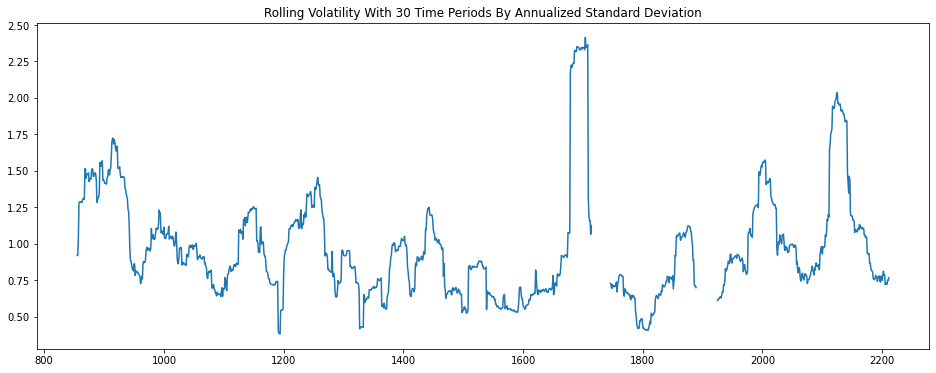

Iteration:      1,   Func. Count:      7,   Neg. LLF: -53.05998866163634
Iteration:      2,   Func. Count:     22,   Neg. LLF: -167.0810941833073
Iteration:      3,   Func. Count:     30,   Neg. LLF: -239.26367785563696
Iteration:      4,   Func. Count:     38,   Neg. LLF: -253.66458766635202
Iteration:      5,   Func. Count:     46,   Neg. LLF: -260.09989578401087
Iteration:      6,   Func. Count:     54,   Neg. LLF: -267.736774112024
Iteration:      7,   Func. Count:     62,   Neg. LLF: -294.5305828072651
Iteration:      8,   Func. Count:     70,   Neg. LLF: -296.30197117143894
Iteration:      9,   Func. Count:     78,   Neg. LLF: -303.58511955101045
Iteration:     10,   Func. Count:     85,   Neg. LLF: -310.1809730872685
Iteration:     11,   Func. Count:     93,   Neg. LLF: -310.97813291195615
Iteration:     12,   Func. Count:    100,   Neg. LLF: -314.14326596981255
Iteration:     13,   Func. Count:    107,   Neg. LLF: -314.45564670681216
Iteration:     14,   Func. Count:    114,   

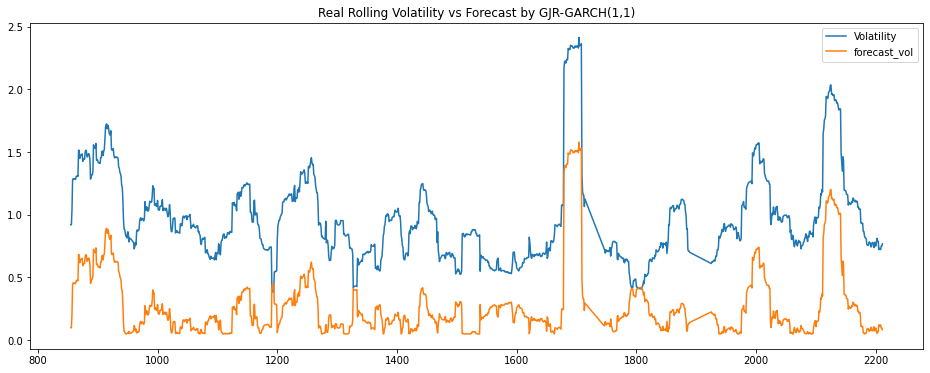



=================================EVALUATION===================================

Root Mean Squared Error of the GARCH(1,1) model is calculated as  0.6971294396705378


In [90]:
df_eth=garch_model(df_eth)

###Garch Ripple 

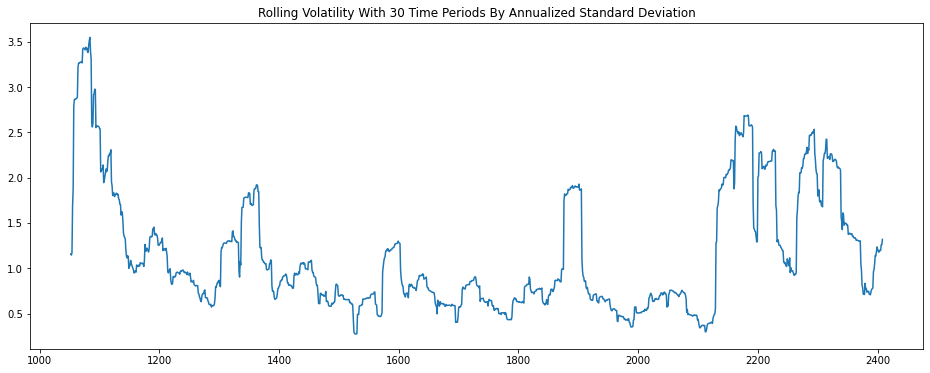

Iteration:      1,   Func. Count:      7,   Neg. LLF: 872.4887845750864
Iteration:      2,   Func. Count:     23,   Neg. LLF: 539.9273508721421
Iteration:      3,   Func. Count:     32,   Neg. LLF: 397.77220551356913
Iteration:      4,   Func. Count:     40,   Neg. LLF: 347.10530280304056
Iteration:      5,   Func. Count:     48,   Neg. LLF: 318.2968962410472
Iteration:      6,   Func. Count:     56,   Neg. LLF: 293.39698476406454
Iteration:      7,   Func. Count:     64,   Neg. LLF: 270.9022411443941
Iteration:      8,   Func. Count:     72,   Neg. LLF: 256.0607419581926
Iteration:      9,   Func. Count:     80,   Neg. LLF: 236.76499247182042
Iteration:     10,   Func. Count:     87,   Neg. LLF: 165.4438489234995
Iteration:     11,   Func. Count:     95,   Neg. LLF: 143.53073061044088
Iteration:     12,   Func. Count:    103,   Neg. LLF: 139.60637085457395
Iteration:     13,   Func. Count:    112,   Neg. LLF: 138.00165524383962
Iteration:     14,   Func. Count:    119,   Neg. LLF: 133

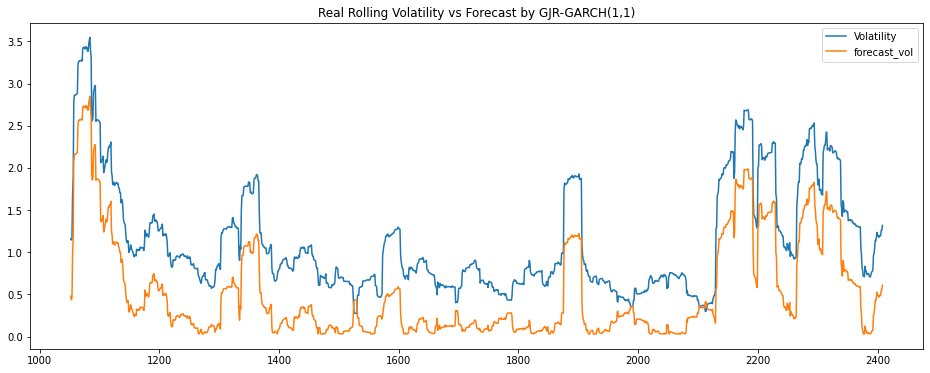



=================================EVALUATION===================================

Root Mean Squared Error of the GARCH(1,1) model is calculated as  0.6222032424652556


In [91]:
df_xrp=garch_model(df_xrp)

###Garch Bitcoin

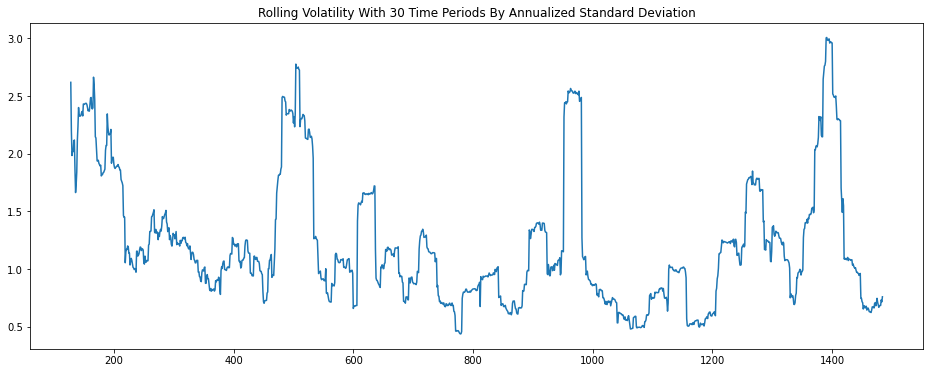

Iteration:      1,   Func. Count:      7,   Neg. LLF: 529.0347256262287
Iteration:      2,   Func. Count:     23,   Neg. LLF: 367.69283969564503
Iteration:      3,   Func. Count:     31,   Neg. LLF: 303.9552233872035
Iteration:      4,   Func. Count:     39,   Neg. LLF: 289.65153406794934
Iteration:      5,   Func. Count:     47,   Neg. LLF: 256.213830792619
Iteration:      6,   Func. Count:     55,   Neg. LLF: 246.0906846209877
Iteration:      7,   Func. Count:     63,   Neg. LLF: 240.32734920977455
Iteration:      8,   Func. Count:     71,   Neg. LLF: 209.19440381528585
Iteration:      9,   Func. Count:     78,   Neg. LLF: 194.07136359965284
Iteration:     10,   Func. Count:     85,   Neg. LLF: 187.8207019184178
Iteration:     11,   Func. Count:     93,   Neg. LLF: 185.3491415291212
Iteration:     12,   Func. Count:    100,   Neg. LLF: 183.25785640391888
Iteration:     13,   Func. Count:    107,   Neg. LLF: 182.2368804477668
Iteration:     14,   Func. Count:    114,   Neg. LLF: 181.7

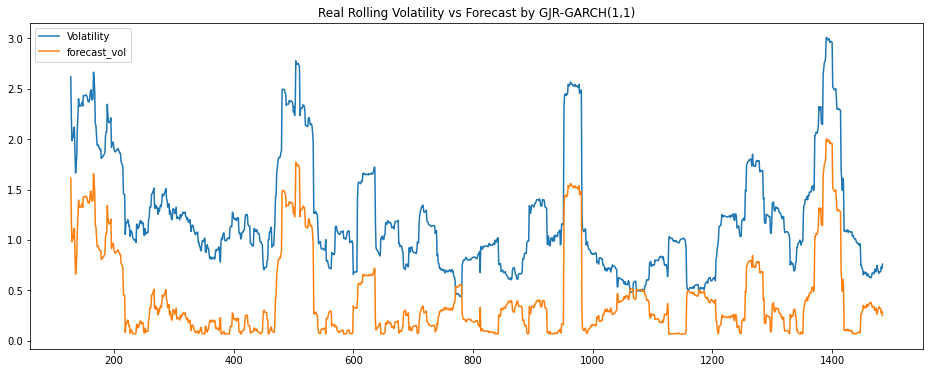



=================================EVALUATION===================================

Root Mean Squared Error of the GARCH(1,1) model is calculated as  0.8071986408637601


In [92]:
df_bit=garch_model(df_bit)

##LSTM

In [93]:
def lstm_model(df):
  training_set = df.iloc[:, 10:11].values
  # Create a data structure with 100 timestep and 1 output
  X_train = []
  y_train = []
  for i in range(300, df.shape[0]):
      X_train.append(training_set[i-300:i,0])
      y_train.append(training_set[i,0])
  X_train, y_train = np.array(X_train), np.array(y_train)


  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


  # Initialising the RNN
  regressor = Sequential()

  # Adding the first LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  regressor.add(Dropout(0.1))

  # Adding a second LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10, return_sequences = True))
  regressor.add(Dropout(0.1))

  # Adding a third LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10, return_sequences = True))
  regressor.add(Dropout(0.1))

  # Adding a fourth LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10))
  regressor.add(Dropout(0.1))

  # Adding the output layer
  regressor.add(Dense(units = 1))

  # Compiling the RNN
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

  regressor.summary()


  regressor.save('my_modelp1.h5')
  

  from keras.models import load_model
  regressor = load_model('my_modelp1.h5')


  predicted_stock_price = regressor.predict(X_train)

  # Visualising the results
  plt.figure(figsize=(18,6))
  plt.plot(df.iloc[300:, 10:11].values, color = 'red', label = 'Observed Volatility')
  plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM')
  plt.title('Real Rolling Volatility vs Forecast of LSTM')
  plt.xlabel('Time')
  plt.ylabel('Volatility')
  plt.legend()
  plt.show()


  print("=================================EVALUATION===================================")
  skor2 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[300:], 'Volatility']))
  print("Root Mean Squared Error of the model is calculated as ",skor2)


###LSTM Ethereum

Epoch 1/20
31/31 [==============================] - 22s 434ms/step - loss: 0.3179
Epoch 2/20
31/31 [==============================] - 13s 431ms/step - loss: 0.1410
Epoch 3/20
31/31 [==============================] - 15s 495ms/step - loss: 0.1393
Epoch 4/20
31/31 [==============================] - 13s 436ms/step - loss: 0.1176
Epoch 5/20
31/31 [==============================] - 14s 435ms/step - loss: 0.0934
Epoch 6/20
31/31 [==============================] - 14s 436ms/step - loss: 0.0780
Epoch 7/20
31/31 [==============================] - 14s 436ms/step - loss: 0.0705
Epoch 8/20
31/31 [==============================] - 13s 433ms/step - loss: 0.0560
Epoch 9/20
31/31 [==============================] - 13s 432ms/step - loss: 0.0565
Epoch 10/20
31/31 [==============================] - 13s 432ms/step - loss: 0.0521
Epoch 11/20
31/31 [==============================] - 13s 435ms/step - loss: 0.0543
Epoch 12/20
31/31 [==============================] - 14s 435ms/step - loss: 0.0456
Epoch 13/20
3

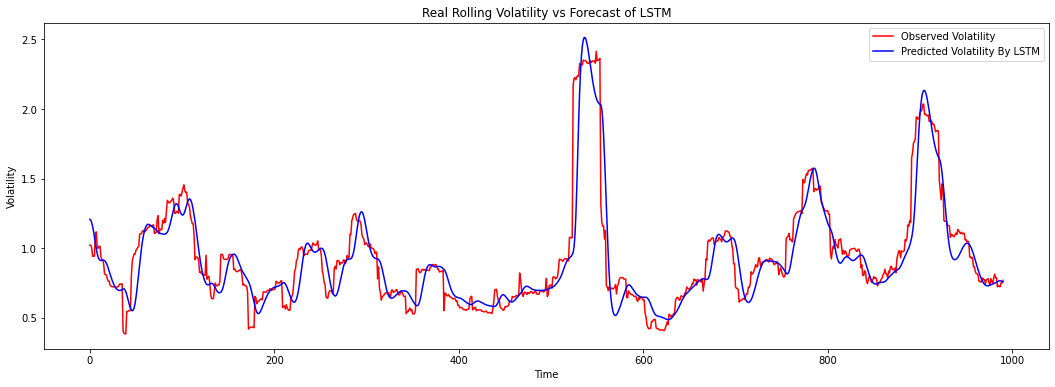

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.5223026860375644


In [94]:
lstm_model(df_eth)

###LSTM Ripple

Epoch 1/20
34/34 [==============================] - 23s 439ms/step - loss: 0.7346
Epoch 2/20
34/34 [==============================] - 15s 446ms/step - loss: 0.3214
Epoch 3/20
34/34 [==============================] - 15s 441ms/step - loss: 0.1834
Epoch 4/20
34/34 [==============================] - 15s 447ms/step - loss: 0.1401
Epoch 5/20
34/34 [==============================] - 15s 443ms/step - loss: 0.1202
Epoch 6/20
34/34 [==============================] - 15s 442ms/step - loss: 0.0982
Epoch 7/20
34/34 [==============================] - 15s 437ms/step - loss: 0.1035
Epoch 8/20
34/34 [==============================] - 15s 440ms/step - loss: 0.0989
Epoch 9/20
34/34 [==============================] - 15s 437ms/step - loss: 0.0865
Epoch 10/20
34/34 [==============================] - 15s 440ms/step - loss: 0.0949
Epoch 11/20
34/34 [==============================] - 15s 441ms/step - loss: 0.0875
Epoch 12/20
34/34 [==============================] - 15s 445ms/step - loss: 0.0877
Epoch 13/20
3

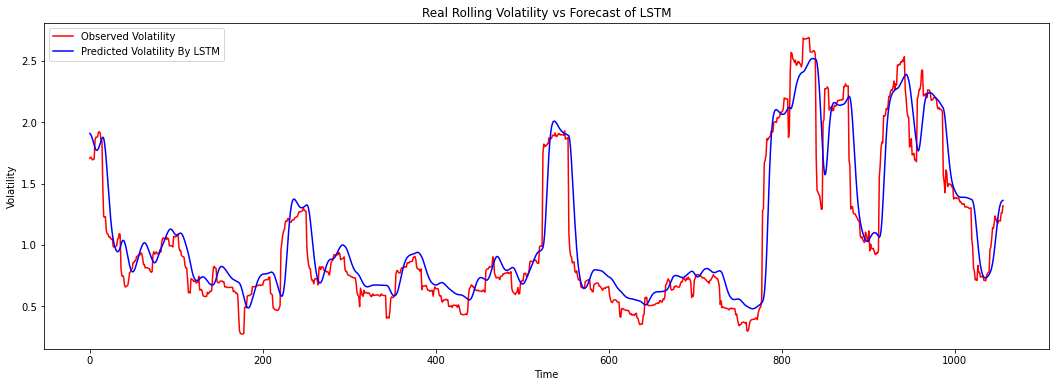

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.8258696266553099


In [95]:
lstm_model(df_xrp)

###LSTM Bitcoin

Epoch 1/20
34/34 [==============================] - 23s 444ms/step - loss: 0.8112
Epoch 2/20
34/34 [==============================] - 15s 438ms/step - loss: 0.3582
Epoch 3/20
34/34 [==============================] - 15s 439ms/step - loss: 0.3304
Epoch 4/20
34/34 [==============================] - 15s 438ms/step - loss: 0.2309
Epoch 5/20
34/34 [==============================] - 15s 439ms/step - loss: 0.1706
Epoch 6/20
34/34 [==============================] - 15s 437ms/step - loss: 0.1395
Epoch 7/20
34/34 [==============================] - 15s 441ms/step - loss: 0.1076
Epoch 8/20
34/34 [==============================] - 15s 439ms/step - loss: 0.0923
Epoch 9/20
34/34 [==============================] - 15s 437ms/step - loss: 0.0917
Epoch 10/20
34/34 [==============================] - 15s 444ms/step - loss: 0.0841
Epoch 11/20
34/34 [==============================] - 15s 440ms/step - loss: 0.0847
Epoch 12/20
34/34 [==============================] - 15s 444ms/step - loss: 0.0718
Epoch 13/20
3

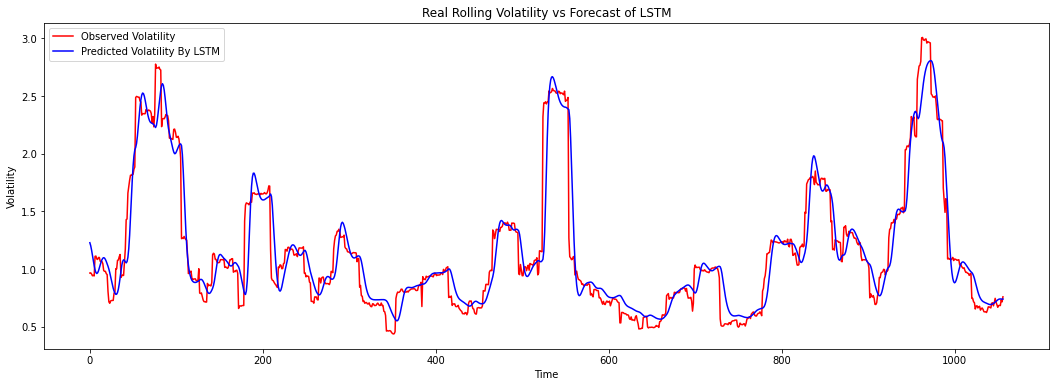

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.7810342929066005


In [96]:
lstm_model(df_bit)

##GARCH+LSTM

In [97]:
### Neural-Garch Model (Combining Garch(1,1) and LSTM)


def garch_lstm_model(df):
  training_set = df.iloc[:, 10:12].values
  # Create a data structure with 100 timestep and 1 output
  X_train = []
  y_train = []
  for i in range(300, df.shape[0]):
      X_train.append(training_set[i-300:i,:])
      y_train.append(training_set[i,0])
  X_train, y_train = np.array(X_train), np.array(y_train)


  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))     ##Did 1 instead of 2


  # Initialising the RNN
  regressor = Sequential()

  # Adding the first LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 2))) #,1 instead of ,2 in the end)
  regressor.add(Dropout(0.1))

  # Adding a second LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10, return_sequences = True))
  regressor.add(Dropout(0.1))

  # Adding a third LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10, return_sequences = True))
  regressor.add(Dropout(0.1))

  # Adding a fourth LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = 10))
  regressor.add(Dropout(0.1))

  # Adding the output layer
  regressor.add(Dense(units = 1))

  # Compiling the RNN
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)


  regressor.save('my_modelp2.h5')



  from keras.models import load_model
  regressor = load_model('my_modelp2.h5')


  predicted_stock_price = regressor.predict(X_train)


  # Visualising the results
  plt.figure(figsize=(18,6))
  plt.plot(df.iloc[300:, 10:11].values, color = 'red', label = 'Observed Volatility')
  plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM_GJR-GARCH(1,1)')
  plt.title('Real Rolling Volatility vs Forecast of LSTM_GJR-GARCH(1,1)')
  plt.xlabel('Time')
  plt.ylabel('Volatility')
  plt.legend()
  plt.show()

  print("=================================EVALUATION===================================")
  skor3 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[300:], 'Volatility']))
  print("Root Mean Squared Error of the model is calculated as ",skor3)


### GARCH+LSTM Ethereum

Epoch 1/20
31/31 [==============================] - 21s 432ms/step - loss: 0.5833
Epoch 2/20
31/31 [==============================] - 13s 435ms/step - loss: 0.1631
Epoch 3/20
31/31 [==============================] - 13s 430ms/step - loss: 0.1518
Epoch 4/20
31/31 [==============================] - 14s 441ms/step - loss: 0.1143
Epoch 5/20
31/31 [==============================] - 13s 436ms/step - loss: 0.0891
Epoch 6/20
31/31 [==============================] - 13s 434ms/step - loss: 0.0807
Epoch 7/20
31/31 [==============================] - 13s 430ms/step - loss: 0.0769
Epoch 8/20
31/31 [==============================] - 13s 424ms/step - loss: 0.0548
Epoch 9/20
31/31 [==============================] - 13s 427ms/step - loss: 0.0537
Epoch 10/20
31/31 [==============================] - 13s 430ms/step - loss: 0.0504
Epoch 11/20
31/31 [==============================] - 13s 418ms/step - loss: 0.0539
Epoch 12/20
31/31 [==============================] - 13s 424ms/step - loss: 0.0466
Epoch 13/20
3

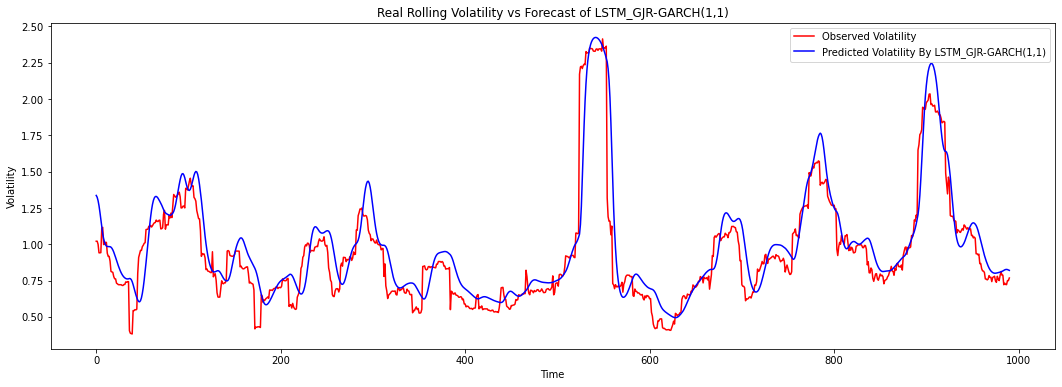

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.542264490558765


In [98]:
garch_lstm_model(df_eth)

###GARCH+LSTM Ripple

Epoch 1/20
34/34 [==============================] - 22s 423ms/step - loss: 0.6675
Epoch 2/20
34/34 [==============================] - 15s 427ms/step - loss: 0.2512
Epoch 3/20
34/34 [==============================] - 15s 429ms/step - loss: 0.1418
Epoch 4/20
34/34 [==============================] - 14s 419ms/step - loss: 0.1150
Epoch 5/20
34/34 [==============================] - 14s 420ms/step - loss: 0.1127
Epoch 6/20
34/34 [==============================] - 14s 421ms/step - loss: 0.1039
Epoch 7/20
34/34 [==============================] - 14s 424ms/step - loss: 0.0924
Epoch 8/20
34/34 [==============================] - 14s 424ms/step - loss: 0.0856
Epoch 9/20
34/34 [==============================] - 14s 422ms/step - loss: 0.0935
Epoch 10/20
34/34 [==============================] - 14s 425ms/step - loss: 0.0802
Epoch 11/20
34/34 [==============================] - 15s 427ms/step - loss: 0.0836
Epoch 12/20
34/34 [==============================] - 14s 420ms/step - loss: 0.0842
Epoch 13/20
3

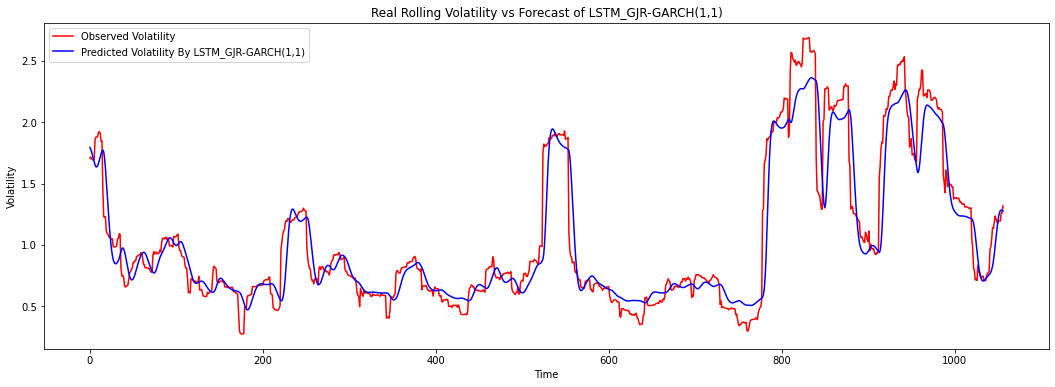

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.8050234146532611


In [99]:
garch_lstm_model(df_xrp)

###GARCH+LSTM Bitcoin

Epoch 1/20
34/34 [==============================] - 22s 426ms/step - loss: 0.7704
Epoch 2/20
34/34 [==============================] - 15s 431ms/step - loss: 0.2376
Epoch 3/20
34/34 [==============================] - 15s 430ms/step - loss: 0.1757
Epoch 4/20
34/34 [==============================] - 14s 423ms/step - loss: 0.1540
Epoch 5/20
34/34 [==============================] - 15s 428ms/step - loss: 0.1316
Epoch 6/20
34/34 [==============================] - 14s 423ms/step - loss: 0.1130
Epoch 7/20
34/34 [==============================] - 15s 429ms/step - loss: 0.0965
Epoch 8/20
34/34 [==============================] - 15s 429ms/step - loss: 0.0899
Epoch 9/20
34/34 [==============================] - 15s 427ms/step - loss: 0.0860
Epoch 10/20
34/34 [==============================] - 15s 431ms/step - loss: 0.0920
Epoch 11/20
34/34 [==============================] - 14s 422ms/step - loss: 0.0841
Epoch 12/20
34/34 [==============================] - 14s 421ms/step - loss: 0.0780
Epoch 13/20
3

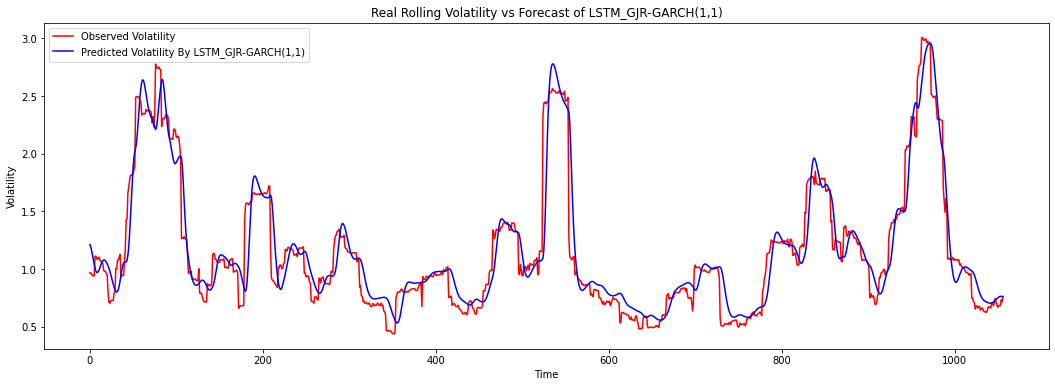

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.7871026261560092


In [100]:
garch_lstm_model(df_bit)